# Molecule generation workflow

This note book has the workflow for these two main tasks 

- Create Feature Vectors
- Design new ligands

To run this notebook please create a conda environment with this command "conda env create -n new-env-name -f environment.yml". This notebook is tested on a Windows 64 bit machine. 

I have used Mols2grid and Py3Dmol for visualisation purpose. Prolif is used to generate the protein ligand interaction fingerprint. Smina is used for docking purpose and Openbabel is used for file formt conversion.
This notebook is divided in four parts
- Data preperation
- Protein ligand interaction fingerprint generation
- Design of new molecules
- Selecting ligands for the target
- Summary

The data files are stored in data folder and utils.py has the methods to generate the fingerprints and design new molecules.

In [1]:
import pandas as pd

import mols2grid
import prolif as plf
import py3Dmol
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, PandasTools, Descriptors, DataStructs

from utils import create_list_of_molecules, align_molecules, CreateProlifFingerPrint, design_new_molecules, create_sdf_file_from_molecules


## Data preperation

In [2]:
mols2grid.display("data/ligands.sdf")

MolGridWidget()

There are 33 ligands in this data set. The first ligand, FluoroUracil (URF) is present in the PDB. I have decided to remove this ligand from further analysis since it is quite different than the rest of the series, which are part of same series. Also, in orer to get a good docking performance, I prefer to have the ligands nicely aligned and with URF that will be problematic. 

I have prepared the ligands outside in Pymol. I have also used pdb entry 2ITO as the structure of the target and the bound ligand IRE as reference ligand for docking. the PDB file has been cleaned and processed (Hydrogen added) outside using Pymol. The processed files are in data folder.

In [3]:
align_molecules(ligands_sdf_file="data/ligands_modified.sdf", output_file_path = "data/aligned_molecules_03A.sdf")

In [4]:
view = py3Dmol.view()
view.addModels(open("data/aligned_molecules_03A.sdf","r").read(),format="sdf")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Protein ligand interaction fingerprint generation

### Prepare protein ligand complex for fingerprint generation

In order to generate the protein ligand fingerprint, I need to generate the protein ligand complex. I will use SMINA docking program to dock the ligands in the receptor structure. I have used openbabel to convert the files

In [5]:
!obabel "data/aligned_molecules_03A.sdf" -O "data/aligned_molecules_processed.sdf" -p

32 molecules converted


In [6]:
!obabel "data/2ito_clean.pdb" -O "data/2ito_processed.pdb" -p

*** Open Babel Warning  in OpenBabel::OBMol::PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is data/2ito_clean.pdb)

1 molecule converted


Next step the ligands will be docked using IRE as reference ligand

In [7]:
!smina -r "data/2ito_processed.pdb" -l "data/aligned_molecules_processed.sdf" --autobox_ligand "data/2ito_IRE.sdf" --exhaustiveness 16 --num_modes 1 -o "data/docked_aligned_ligands.sdf"

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -950212448

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


In [8]:
view2 = py3Dmol.view()
view2.addModel(open("data/2ito_processed.pdb","r").read(),format="pdb")

view2.addModels(open("data/docked_aligned_ligands.sdf","r").read(),format="sdf")
view2.zoomTo()
view2.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Fingerprint generation

Once we have the protein ligand complexes, now we will generate the fingerprint. CreateProlifFingerprint class uses Prolif and has two methods, one to generate fingerprint for a single ligand and another to generate fingerprint for docked poses, respectively. 

In [9]:
fp_generator = CreateProlifFingerPrint(receptor_file="data/2ito_processed.pdb")

We can use, any protein ligand complex from our docked poses to gnerate the fingerprint. In this example, I have used the first ligand. 

In [10]:
fp_protien_ligand = fp_generator.create_fingerprint_of_reference_ligand(sdf_file="data/docked_aligned_ligands.sdf", index=1)

[11:16:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
fp_protien_ligand

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x21445567070>

## Design of new molecules

In the next step, I will follow a workflow to design new molecules. I will use Rdkit Brics to first generate fragments by decomposing those 32 ligands obtained from binding db. Then I will use Brics Build to re-join those fragments to create new ligands. Brics build is a simple yet powerful tool to desgin new ligands and very useful to create seed moelcules for generative design task. Brics generated compounds are likely to be synthesisable since they are built from Brics fragments.

In [12]:
list_of_ligand_molecules = create_list_of_molecules("data/ligands_modified.sdf")

I will generate only 250 molecules to keep the docking run less time consuming. But we can see some interesting molecules, if we increase the number of molecules. Please reduce the number of molecules in next cell if you would like to make the process faster.

In [13]:
new_molecules = design_new_molecules(list_of_molecules=list_of_ligand_molecules, number_of_molecules=250)

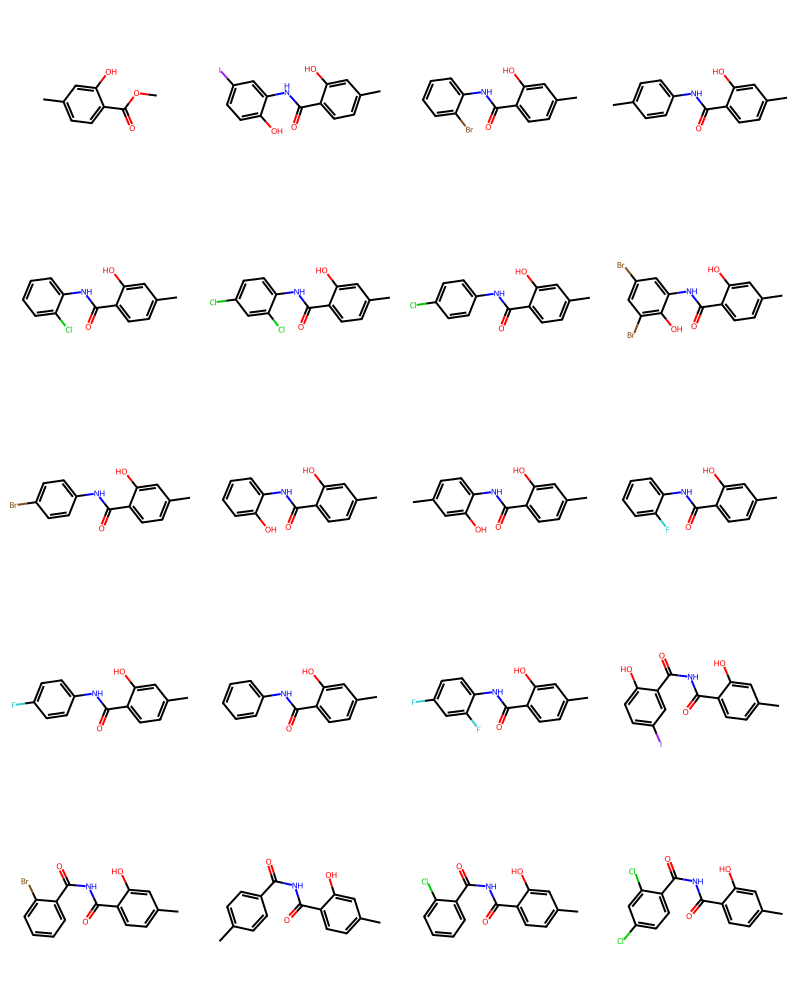

In [14]:
Draw.MolsToGridImage(new_molecules[0:20], molsPerRow=4, subImgSize=(200, 200))

In [15]:
create_sdf_file_from_molecules(list_of_molecules=new_molecules, file_name="data/de_novo_ligands.sdf")

In the next step, I will load the sdf file in a data frame and generate some properties (Molecular weight, Log p , Number of H donors and acceptors). Then I will filter the generated molecules only to keep those, which obey rule of 5.


In [16]:
df = PandasTools.LoadSDF("data/de_novo_ligands.sdf")

In [17]:
df.head()

,ID,ROMol
0,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...
1,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...
2,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...
3,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...
4,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...


In [18]:
df["MolWt"] = df["ROMol"].apply(Descriptors.ExactMolWt)
df["LogP"] = df["ROMol"].apply(Descriptors.MolLogP)
df["NumHDonors"] = df["ROMol"].apply(Descriptors.NumHDonors)
df["NumHAcceptors"] = df["ROMol"].apply(Descriptors.NumHAcceptors)


In [19]:
df.head()

,ID,ROMol,MolWt,LogP,NumHDonors,NumHAcceptors
0,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...,166.062994,1.48722,1,3
1,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...,368.986191,3.26312,3,3
2,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...,305.005141,3.71542,2,2
3,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...,241.110279,3.26134,2,2
4,,<rdkit.Chem.rdchem.Mol object at 0x00000214453...,261.055656,3.60632,2,2


In [20]:
df_modified = df.query("MolWt > 160 & MolWt < 500 & LogP < 5 &  NumHDonors < 5 & NumHAcceptors < 10")

In [21]:
df_modified.shape

(181, 6)

In [22]:
PandasTools.WriteSDF(df_modified, "data/filtered_ligands.sdf", molColName="ROMol", properties=list(df_modified.columns) )

### Docking of new ligands 

In [23]:
!obabel "data/filtered_ligands.sdf" -O "data/filtered_ligands_processed.sdf" -p

181 molecules converted


In [24]:
!smina -r "data/2ito_processed.pdb" -l "data/filtered_ligands_processed.sdf" --autobox_ligand "data/2ito_IRE.sdf" --num_modes 1 -o "data/docked_filtered_ligands.sdf" 

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -576968964

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


In [25]:
!obabel "data/docked_filtered_ligands.sdf" -O "data/docked_filtered_ligands.sdf" -p

181 molecules converted


## Selecting ligands for the target

### Generate fingerprint similarity between reference ligand and docked poses

I will use the first ligand as a query ligand and  generate fingerprint. Then I will generate finger pirnt of all the docked poses by using the method discussed above. 

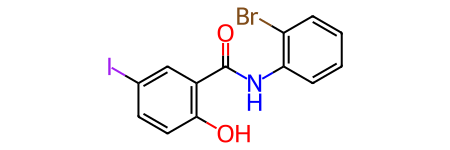

In [26]:
list_of_ligand_molecules[1]

In [27]:
fp_generator = CreateProlifFingerPrint(receptor_file="data/2ito_processed.pdb")

In [28]:
ref_fp = fp_generator.create_fingerprint_of_reference_ligand(sdf_file = "data/docked_aligned_ligands.sdf", index = 1)

[11:36:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


  0%|          | 0/1 [00:00<?, ?it/s]

The code below is based on the examples mentioned in the Prolif doc.

In [29]:
ref_df = ref_fp.to_dataframe(index_col="Pose")
ref_df.rename(index={0: -1}, inplace=True)
# set the ligand name to be the same as poses
ref_df.rename(columns={"reference": ref_df.columns.levels[0][0]}, inplace=True)

In [30]:
poses_fp = fp_generator.create_fingerprints_of_docking_poses(sdf_file="data/docked_filtered_ligands.sdf")

  0%|          | 0/181 [00:00<?, ?it/s]

In [31]:
poses_df = poses_fp.to_dataframe(index_col=False)

In [32]:
df_ref_poses = (
    pd.concat([ref_df, poses_df])
    .fillna(False)
    .sort_index(
        axis=1,
        level=1,
        key=lambda index: [plf.ResidueId.from_string(x) for x in index],
    )
)

Next we will convert the fingerprints to explicitbitvectors in order to calculate tanimoto similarity.

In [33]:
bitvectors = plf.to_bitvectors(df_ref_poses)
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors[1:])


Next we will load the docked sdf files and the tanimoto similarity values in a data frame and will only keep the ligands that has tanimoto similairty over 0.6 with the reference ligands. This will hopefully give us ligands that will have similar or close interaction pattern to the reference ligand.

In [34]:
result_df = PandasTools.LoadSDF("data/docked_filtered_ligands.sdf")

In [35]:
result_df["plif_sim"] = tanimoto_sims

In [36]:
result_df["smiles"] = result_df["ROMol"].apply(lambda mol: Chem.MolToSmiles(mol))

In [37]:
result_df.head()

,minimizedAffinity,ID,ROMol,plif_sim,smiles
0,-5.73267,,<rdkit.Chem.rdchem.Mol object at 0x0000021448B...,0.347826,COC(=O)c1ccc(C)cc1O
1,-7.97996,,<rdkit.Chem.rdchem.Mol object at 0x0000021448B...,0.772727,Cc1ccc(C(=O)Nc2cc(I)ccc2O)c(O)c1
2,-8.21627,,<rdkit.Chem.rdchem.Mol object at 0x0000021448B...,0.772727,Cc1ccc(C(=O)Nc2ccccc2Br)c(O)c1
3,-8.17403,,<rdkit.Chem.rdchem.Mol object at 0x0000021448C...,0.625000,Cc1ccc(NC(=O)c2ccc(C)cc2O)cc1
4,-7.45228,,<rdkit.Chem.rdchem.Mol object at 0x0000021448C...,0.636364,Cc1ccc(C(=O)Nc2ccccc2Cl)c(O)c1


In [38]:
result_df_filtered = result_df.query("plif_sim > 0.7")

In [39]:
result_df_filtered.shape

(43, 5)

In [40]:
mols2grid.display(result_df_filtered, smiles_col="smiles")

MolGridWidget()

## Summary

This notebook describes a method to generate protein ligand interaction fingerprint from a prtoen ligand complex. We can create protein ligand finger print of a protein ligand ligand complex using CreateProlifFingerprint class. There is also a workflow to design new ligands for a target using a structure based approach, where the fingerprint similarity was used as a filter to identify potential ligands that can have similar interaction with the receptor as the reference ligand.

